# Eval 4: Uncertainty Calibration

**Biological question**: Are the model's confidence estimates meaningful?

**Metrics**: Expected Calibration Error (ECE), reliability diagrams, uncertainty-error correlation

**Story**: For active learning and experiment prioritization, we need to trust that high uncertainty means "I don't know" not "random noise." Well-calibrated uncertainty enables rational experiment selection.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

from eval_common import EvalContext, update_eval_report

In [2]:
ctx = EvalContext()
results = ctx.run_test_inference()

using cpu
Input Bank (DNA): torch.Size([1250, 1536])
<All keys matched successfully>
Decoder loaded
found 4 shards for split test
loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0002.npz


Running inference:  26%|███████▋                      | 312/1213 [02:39<07:40,  1.95it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0001.npz


Running inference:  52%|███████████████▍              | 625/1213 [05:07<04:46,  2.05it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0000.npz


Running inference:  77%|███████████████████████▏      | 937/1213 [07:47<02:23,  1.92it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0003.npz


Running inference: 100%|█████████████████████████████| 1213/1213 [10:04<00:00,  2.01it/s]


Aggregated 286 perturbations, 38816 samples


In [3]:
pred_deltas = results['sample_pred_deltas']
real_deltas = results['sample_real_deltas']
sample_logvars = results['sample_logvars']
pert_ids = results['sample_pert_ids']

sample_mse = np.mean((pred_deltas - real_deltas)**2, axis=1)
sample_uncertainty = sample_logvars.mean(axis=1)

print(f'Samples: {len(sample_mse)}')
print(f'MSE range: [{sample_mse.min():.4f}, {sample_mse.max():.4f}]')
print(f'Uncertainty range: [{sample_uncertainty.min():.4f}, {sample_uncertainty.max():.4f}]')

Samples: 38816
MSE range: [0.2634, 1.7054]
Uncertainty range: [-0.2892, 0.1319]


## Uncertainty-Error Correlation

First, let's check if higher uncertainty correlates with higher error. A well-calibrated model should show positive correlation.

In [4]:
pearson_r, pearson_p = pearsonr(sample_uncertainty, sample_mse)
spearman_r, spearman_p = spearmanr(sample_uncertainty, sample_mse)

print('UNCERTAINTY-ERROR CORRELATION')
print(f'  Pearson R:  {pearson_r:.4f} (p={pearson_p:.2e})')
print(f'  Spearman R: {spearman_r:.4f} (p={spearman_p:.2e})')

UNCERTAINTY-ERROR CORRELATION
  Pearson R:  0.1913 (p=8.57e-317)
  Spearman R: 0.1786 (p=9.99e-276)


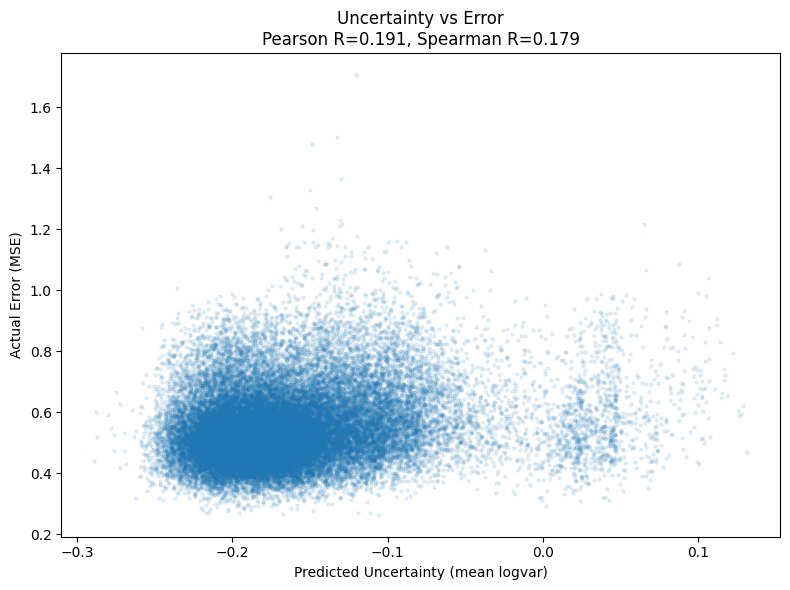

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(sample_uncertainty, sample_mse, alpha=0.1, s=5)
ax.set_xlabel('Predicted Uncertainty (mean logvar)')
ax.set_ylabel('Actual Error (MSE)')
ax.set_title(f'Uncertainty vs Error\nPearson R={pearson_r:.3f}, Spearman R={spearman_r:.3f}')
plt.tight_layout()
plt.show()

## Calibration Analysis

Bin samples by predicted uncertainty and compute actual error in each bin. For calibration, we want the mean error to increase monotonically with uncertainty.

In [6]:
n_bins = 10
percentiles = np.linspace(0, 100, n_bins + 1)
bin_edges = np.percentile(sample_uncertainty, percentiles)

bin_mean_uncertainty = []
bin_mean_error = []
bin_std_error = []
bin_counts = []

for i in range(n_bins):
    mask = (sample_uncertainty >= bin_edges[i]) & (sample_uncertainty < bin_edges[i+1])
    if i == n_bins - 1:
        mask = (sample_uncertainty >= bin_edges[i]) & (sample_uncertainty <= bin_edges[i+1])
    
    bin_mean_uncertainty.append(sample_uncertainty[mask].mean())
    bin_mean_error.append(sample_mse[mask].mean())
    bin_std_error.append(sample_mse[mask].std())
    bin_counts.append(mask.sum())

bin_mean_uncertainty = np.array(bin_mean_uncertainty)
bin_mean_error = np.array(bin_mean_error)
bin_std_error = np.array(bin_std_error)
bin_counts = np.array(bin_counts)

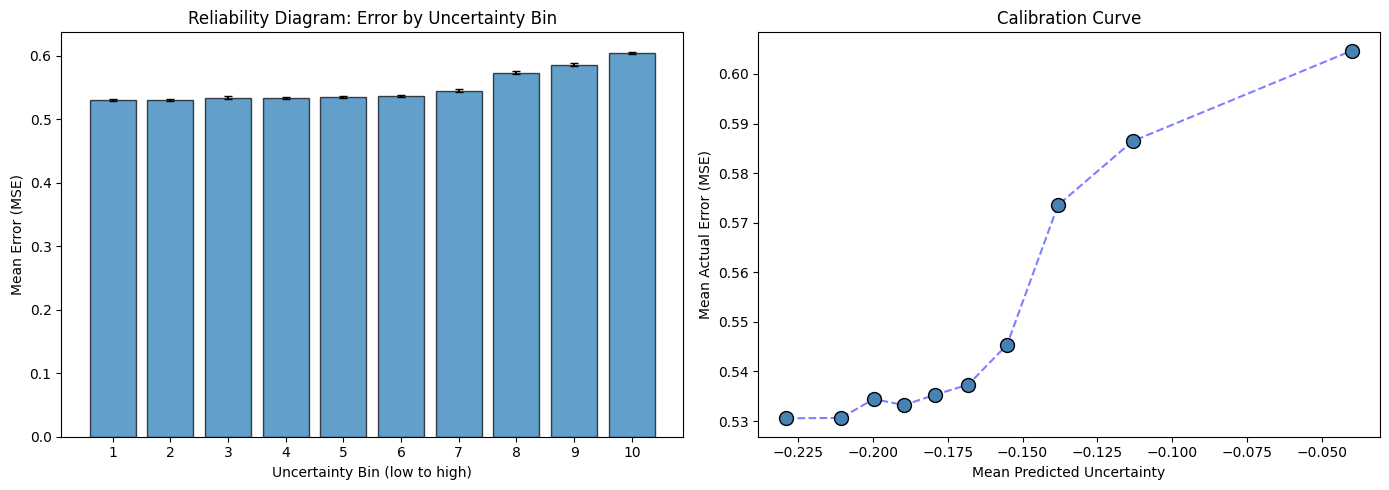

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(n_bins), bin_mean_error, yerr=bin_std_error/np.sqrt(bin_counts), capsize=3, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Uncertainty Bin (low to high)')
axes[0].set_ylabel('Mean Error (MSE)')
axes[0].set_title('Reliability Diagram: Error by Uncertainty Bin')
axes[0].set_xticks(range(n_bins))
axes[0].set_xticklabels([f'{i+1}' for i in range(n_bins)])

axes[1].scatter(bin_mean_uncertainty, bin_mean_error, s=100, c='steelblue', edgecolor='black', zorder=3)
axes[1].plot(bin_mean_uncertainty, bin_mean_error, 'b--', alpha=0.5, zorder=2)
axes[1].set_xlabel('Mean Predicted Uncertainty')
axes[1].set_ylabel('Mean Actual Error (MSE)')
axes[1].set_title('Calibration Curve')

plt.tight_layout()
plt.show()

## Expected Calibration Error (ECE)

ECE measures the average gap between predicted uncertainty and actual error, weighted by bin size. Lower is better.

In [8]:
uncertainty_normalized = (sample_uncertainty - sample_uncertainty.min()) / (sample_uncertainty.max() - sample_uncertainty.min())
error_normalized = (sample_mse - sample_mse.min()) / (sample_mse.max() - sample_mse.min())

bin_edges_norm = np.linspace(0, 1, n_bins + 1)
ece = 0.0
calibration_gaps = []

for i in range(n_bins):
    mask = (uncertainty_normalized >= bin_edges_norm[i]) & (uncertainty_normalized < bin_edges_norm[i+1])
    if i == n_bins - 1:
        mask = (uncertainty_normalized >= bin_edges_norm[i]) & (uncertainty_normalized <= bin_edges_norm[i+1])
    
    if mask.sum() > 0:
        avg_uncertainty = uncertainty_normalized[mask].mean()
        avg_error = error_normalized[mask].mean()
        gap = abs(avg_uncertainty - avg_error)
        calibration_gaps.append(gap)
        ece += (mask.sum() / len(sample_mse)) * gap

print(f'Expected Calibration Error (ECE): {ece:.4f}')
print(f'  (Lower is better, 0 = perfectly calibrated)')

Expected Calibration Error (ECE): 0.1100
  (Lower is better, 0 = perfectly calibrated)


## Monotonicity Check

For good calibration, error should increase monotonically with uncertainty.

In [9]:
monotonic_increases = sum(1 for i in range(len(bin_mean_error)-1) if bin_mean_error[i+1] > bin_mean_error[i])
monotonicity_score = monotonic_increases / (n_bins - 1)

print('MONOTONICITY ANALYSIS')
print(f'  Bins where error increases: {monotonic_increases}/{n_bins-1}')
print(f'  Monotonicity score: {monotonicity_score:.2%}')
print()
print('Error by bin:')
for i, (err, count) in enumerate(zip(bin_mean_error, bin_counts)):
    trend = ''
    if i > 0:
        trend = ' (+)' if err > bin_mean_error[i-1] else ' (-)'
    print(f'  Bin {i+1}: MSE={err:.4f}{trend} (n={count:,})')

MONOTONICITY ANALYSIS
  Bins where error increases: 8/9
  Monotonicity score: 88.89%

Error by bin:
  Bin 1: MSE=0.5305 (n=3,882)
  Bin 2: MSE=0.5306 (+) (n=3,881)
  Bin 3: MSE=0.5344 (+) (n=3,882)
  Bin 4: MSE=0.5332 (-) (n=3,881)
  Bin 5: MSE=0.5353 (+) (n=3,882)
  Bin 6: MSE=0.5374 (+) (n=3,881)
  Bin 7: MSE=0.5454 (+) (n=3,882)
  Bin 8: MSE=0.5736 (+) (n=3,881)
  Bin 9: MSE=0.5864 (+) (n=3,882)
  Bin 10: MSE=0.6047 (+) (n=3,882)


## Uncertainty by Perturbation

Check if certain perturbations consistently have higher uncertainty.

In [10]:
from collections import defaultdict

pert_uncertainties = defaultdict(list)
pert_errors = defaultdict(list)

for i, pid in enumerate(pert_ids):
    pert_uncertainties[pid].append(sample_uncertainty[i])
    pert_errors[pid].append(sample_mse[i])

pert_mean_uncertainty = {pid: np.mean(vals) for pid, vals in pert_uncertainties.items()}
pert_mean_error = {pid: np.mean(vals) for pid, vals in pert_errors.items()}

pert_ids_unique = list(pert_mean_uncertainty.keys())
pert_unc_arr = np.array([pert_mean_uncertainty[pid] for pid in pert_ids_unique])
pert_err_arr = np.array([pert_mean_error[pid] for pid in pert_ids_unique])

pert_pearson, _ = pearsonr(pert_unc_arr, pert_err_arr)
pert_spearman, _ = spearmanr(pert_unc_arr, pert_err_arr)

print('PERTURBATION-LEVEL UNCERTAINTY-ERROR CORRELATION')
print(f'  Pearson R:  {pert_pearson:.4f}')
print(f'  Spearman R: {pert_spearman:.4f}')

PERTURBATION-LEVEL UNCERTAINTY-ERROR CORRELATION
  Pearson R:  0.1405
  Spearman R: 0.0562


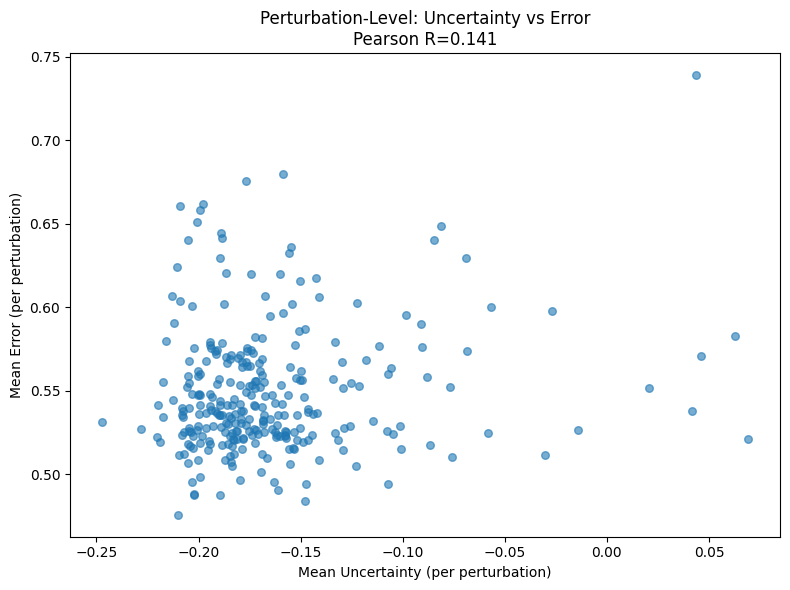

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pert_unc_arr, pert_err_arr, alpha=0.6, s=30)
ax.set_xlabel('Mean Uncertainty (per perturbation)')
ax.set_ylabel('Mean Error (per perturbation)')
ax.set_title(f'Perturbation-Level: Uncertainty vs Error\nPearson R={pert_pearson:.3f}')
plt.tight_layout()
plt.show()

## Benchmark Results

In [12]:
print('='*70)
print('EVAL 4: UNCERTAINTY CALIBRATION - BENCHMARK RESULTS')
print('='*70)
print()
print('CONFIGURATION')
print(f'  Samples: {len(sample_mse):,}')
print(f'  Perturbations: {len(pert_ids_unique)}')
print()
print('SAMPLE-LEVEL CALIBRATION')
print(f'  Uncertainty-Error Pearson R:  {pearson_r:.4f}')
print(f'  Uncertainty-Error Spearman R: {spearman_r:.4f}')
print(f'  Expected Calibration Error:   {ece:.4f}')
print(f'  Monotonicity Score:           {monotonicity_score:.2%}')
print()
print('PERTURBATION-LEVEL CALIBRATION')
print(f'  Uncertainty-Error Pearson R:  {pert_pearson:.4f}')
print(f'  Uncertainty-Error Spearman R: {pert_spearman:.4f}')

EVAL 4: UNCERTAINTY CALIBRATION - BENCHMARK RESULTS

CONFIGURATION
  Samples: 38,816
  Perturbations: 286

SAMPLE-LEVEL CALIBRATION
  Uncertainty-Error Pearson R:  0.1913
  Uncertainty-Error Spearman R: 0.1786
  Expected Calibration Error:   0.1100
  Monotonicity Score:           88.89%

PERTURBATION-LEVEL CALIBRATION
  Uncertainty-Error Pearson R:  0.1405
  Uncertainty-Error Spearman R: 0.0562


In [13]:
update_eval_report('eval_4_uncertainty_calibration', {
    'config': {
        'samples': len(sample_mse),
        'perturbations': len(pert_ids_unique)
    },
    'sample_level': {
        'uncertainty_error_pearson': float(pearson_r),
        'uncertainty_error_spearman': float(spearman_r),
        'expected_calibration_error': float(ece),
        'monotonicity_score': float(monotonicity_score)
    },
    'perturbation_level': {
        'uncertainty_error_pearson': float(pert_pearson),
        'uncertainty_error_spearman': float(pert_spearman)
    },
    'bin_analysis': {
        'n_bins': n_bins,
        'bin_mean_errors': [float(e) for e in bin_mean_error],
        'bin_counts': [int(c) for c in bin_counts]
    }
})

Updated eval_report.json
